In [48]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import WMAP9
from astropy.modeling.models import Schechter1D

import grizli
import grizli.catalog
from grizli import utils

from scipy.optimize import curve_fit
import pandas as pd

import eazy
import math

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

grizli version: 1.11.2
eazy-py version: 0.6.8


### Set field & path
`abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756

`gds` = GOODS-South

In [2]:
field = 'abell2744clu-grizli-v7.0' 
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

## Raw photometry

NB: All photometry given in `fnu` flux densities with units of `microJansky` (AB zeropoint = 23.9).

In [3]:
phot = utils.read_catalog(f'{url_path}/{field}-fix_phot_apcorr.fits')
print(type(phot))
phot.columns

<class 'grizli.utils.GTable'>


<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_aper_0','clearp-f356w_flux_aper_1','clearp-f356w_fluxerr_aper_1','clearp-

### Metadata

In [4]:
# General data of source detection
for i, k in enumerate(phot.meta):
    print(f'{k:>36} = {phot.meta[k]}')
    if i > 70:
        print('...')
        break

                             VERSION = 1.2.1
                             MINAREA = 9
                               CLEAN = True
                             DEBCONT = 0.001
                            DEBTHRSH = 32
                         FILTER_TYPE = conv
                           THRESHOLD = 1.5
                            KRONFACT = 2.5
                               KRON0 = 2.4
                               KRON1 = 3.8
                             MINKRON = 8.75000000000009
                            TOTCFILT = F140W
                            TOTCWAVE = 13922.907
                                  ZP = 28.9
                                PLAM = 13922.907
                                 FNU = 1e-08
                                FLAM = 1.4737148e-20
                              UJY2DN = 99.99395614709495
                            DRZ_FILE = abell2744clu-grizli-v7.0-ir_drc_sci.
                            WHT_FILE = abell2744clu-grizli-v7.0-ir_drc_wht.
                 

### Photometric apertures

In [5]:
for i, k in enumerate(phot.meta):
    if k.startswith('APER_'):
        aper_index = k[-1]
        print(f"Aperture index {aper_index}: *diameter* = {phot.meta[k]:4.1f} pixels = {phot.meta[k.replace('APER','ASEC')]:.2f} arcsec")

# Some observers use large apertures for their measurements to account for seeing, tracking, 
# and focus variations, while others use small apertures and apply aperture corrections (how do we choose here?)

Aperture index 0: *diameter* =  9.0 pixels = 0.36 arcsec
Aperture index 1: *diameter* = 12.5 pixels = 0.50 arcsec
Aperture index 2: *diameter* = 17.5 pixels = 0.70 arcsec
Aperture index 3: *diameter* = 25.0 pixels = 1.00 arcsec


In [6]:
# Columns for a particular filter + aperture
# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

aper_index = '1' 

cols = []

for k in phot.colnames:
    if k.startswith('f150w') & k.endswith(aper_index):
        cols.append(k)
        
phot[cols].info()

<GTable length=47888>
         name          dtype  unit    class     n_bad
--------------------- ------- ---- ------------ -----
    f150w_flux_aper_1 float64  uJy MaskedColumn  7259
 f150w_fluxerr_aper_1 float64  uJy MaskedColumn  7259
    f150w_flag_aper_1   int16      MaskedColumn     0
     f150w_bkg_aper_1 float64  uJy MaskedColumn  7259
    f150w_mask_aper_1 float64            Column     0
   f150wn_flux_aper_1 float64  uJy MaskedColumn 31081
f150wn_fluxerr_aper_1 float64  uJy MaskedColumn 31081
   f150wn_flag_aper_1   int16      MaskedColumn     0
    f150wn_bkg_aper_1 float64  uJy MaskedColumn 31082
   f150wn_mask_aper_1 float64            Column     0
         f150w_corr_1 float64  uJy       Column     0
        f150w_ecorr_1 float64  uJy       Column     0
          f150w_tot_1 float64  uJy       Column     0
         f150w_etot_1 float64  uJy       Column     0
        f150wn_corr_1 float64  uJy       Column     0
       f150wn_ecorr_1 float64  uJy       Column     0
      

### Photometric bands

- NIRCam filters generally have "clear" in the filter name, which is the element in the `pupil` wheel.
- Filters that start with `clearp` are generally the long-wavelength NIRISS filters.
- Filters with names that end in `wn` are the NIRISS versions, e.g., `f200wn-clear` for NIRISS and `f200w-clear` for NIRCam
- HST filters ending in "u" are the WFC3/UVIS versions, e.g., `f814wu`

In [7]:
# bands 
count = 0
for k in phot.colnames:
    if k.endswith('_tot_1'): 
        count += 1
        print(f"{count:>2} {k.split('_flux')[0]}")

 1 clearp-f356w_tot_1
 2 clearp-f444w_tot_1
 3 f090w_tot_1
 4 f105w_tot_1
 5 f115w_tot_1
 6 f115wn_tot_1
 7 f125w_tot_1
 8 f140w_tot_1
 9 f150w_tot_1
10 f150wn_tot_1
11 f160w_tot_1
12 f200w_tot_1
13 f200wn_tot_1
14 f277w_tot_1
15 f356w_tot_1
16 f410m_tot_1
17 f435w_tot_1
18 f444w_tot_1
19 f475w_tot_1
20 f606w_tot_1
21 f775w_tot_1
22 f814w_tot_1


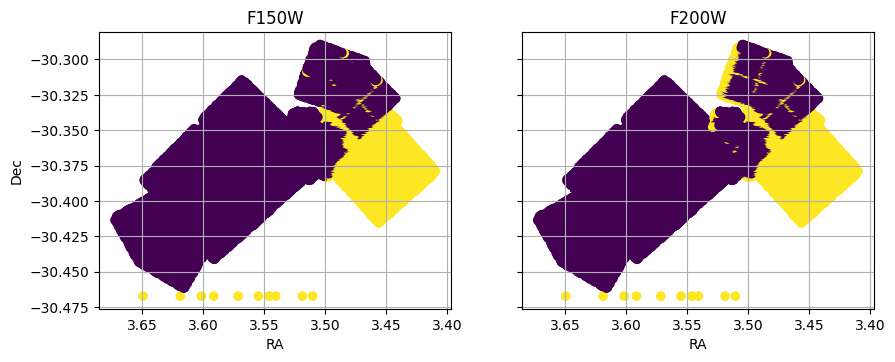

In [8]:
# Missing data are *masked* (?)

# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].scatter(phot['ra'], phot['dec'], c=phot['f150w_flux_aper_1'].mask)
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_title('F150W') # what are (JADES/FRESCO)?
axes[1].scatter(phot['ra'], phot['dec'], c=phot['f200w_flux_aper_1'].mask)
axes[1].set_title('F200W')
axes[1].set_xlabel('RA')

axes[0].set_xlim(*axes[0].get_xlim()[::-1])
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)
for ax in axes:
    ax.set_aspect(1./cosd)
    ax.grid()

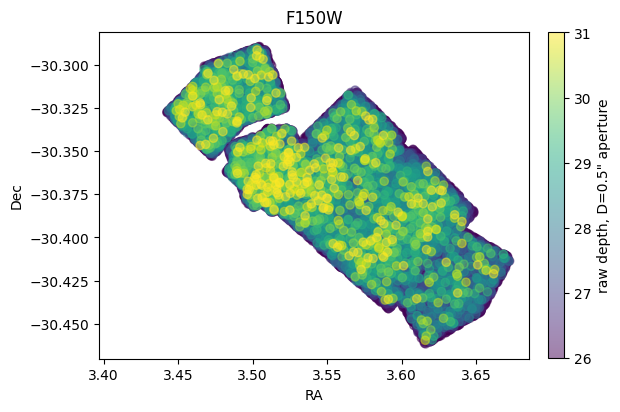

In [9]:
# 5-sigma depth in the D=0.5" aperture
depth = 23.9 - 2.5*np.log10(phot['f150w_flux_aper_1']*5) # how do you get 23.9?
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_aspect(1./cosd)
so = np.argsort(depth)
sc = ax.scatter(phot['ra'][so], phot['dec'][so], c=depth[so], vmin=26, vmax=31, alpha=0.5)
ax.set_xlim(*axes[0].get_xlim()[::-1])
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('F150W')
cb = plt.colorbar(sc,fraction=0.035, pad=0.04)
cb.set_label('raw depth, D=0.5" aperture')

### Point sources

In [10]:
#fig, ax = plt.subplots(1,1,figsize=(8, 6))
#in_jades = ~phot['f200w_flux_aper_1'].mask
#ax.scatter(phot['mag_auto'], phot['flux_radius'], alpha=0.2, c=in_jades, vmin=0, vmax=2, cmap='viridis', marker='.')
#ax.set_ylim(0,10); ax.set_xlim(17, 32)

#ax.set_xlabel('mag_auto (detection band)'); ax.set_ylabel('flux_radius') # limit from -1 because below that pixels are so small it gets noise (half light radius)


In [11]:
phot.columns

<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_aper_0','clearp-f356w_flux_aper_1','clearp-f356w_fluxerr_aper_1','clearp-

## RA vs Dec

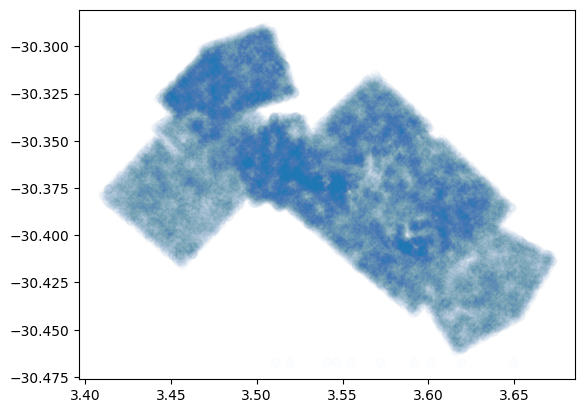

In [12]:
# RA vs Dec
plt.scatter(phot['ra'], phot['dec'], vmin=3.4, vmax=3.6, alpha=0.01)
# plt.scatter(phot['x_world'], phot['y_world'], vmin=3.4, vmax=3.6, alpha=0.01) # <-- celestial coordinates

# Photometric redshifts

In [13]:
import eazy.hdf5

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

Read default param file: /home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 47888
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f115w_tot_1 f115w_etot_1 (364): jwst_nircam_f115w
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f150wn_tot_1 f150wn_etot_1 (310): niriss-f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f200w_tot_1 f200w_etot_1 (366): jwst_nircam_f200w
f200wn_tot_1 f200wn_etot_1 (311): niriss-f200w
f277w_tot_1 f277w_etot_1 (375): jwst_nircam_f277w
f356w_tot_1 f356w_etot_1 (376): jwst_nircam_f356w
f410m_tot_1 f410m_etot_1 (383): jwst_nircam_f410m
f435w_tot_1 f435w_etot_1 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f444w_tot_1 f444w_etot_1 (377): jwst_nircam_f444w
f475w_tot_1 

294it [00:02, 106.01it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 16.5 s (n_proc=2,  NOBJ=46441)


In [14]:
#plt.scatter(zout['z_phot'], zout['z_spec'])

Text(0.5, 1.0, 'JWST abell2744clu-grizli-v7.0')

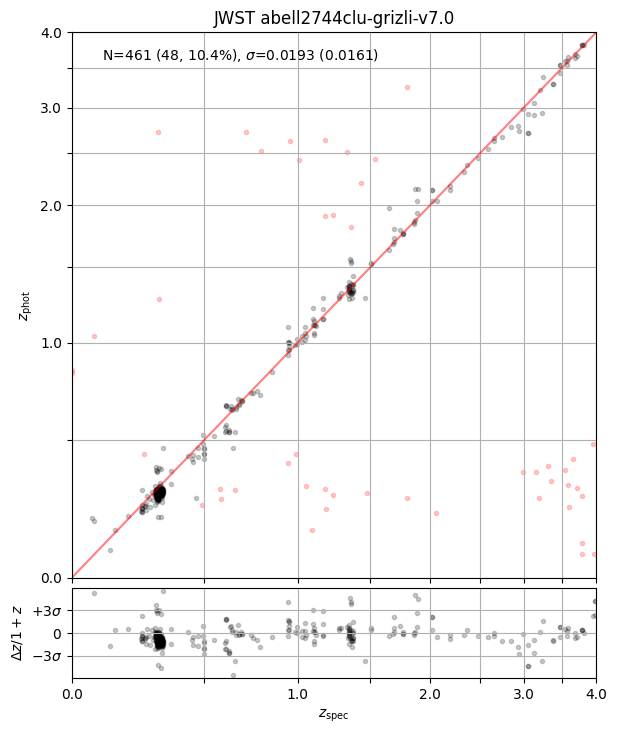

In [15]:
fig = eazy.utils.zphot_zspec(zout['z_phot'], zout['z_spec'], zmax=4)
fig.axes[0].set_title(f'JWST {field}')

In [16]:
# fig = eazy.utils.zphot_zspec(phot['mag_iso'], zout['z_phot'], zmax=8)
mag_f200 = 23.9 - 2.5*np.log10(phot['f200w_tot_1']) # apparent magnitude using zero point of 23.9
mag_f150 = 23.9 - 2.5*np.log10(phot['f150w_tot_1']) # jwst
mag_f160 = 23.9 - 2.5*np.log10(phot['f160w_tot_1']) 
mag_f814 = 23.9 - 2.5*np.log10(phot['f814w_tot_1']) 

# f160-f150 ~ 0
# f200 not masked

Text(0.5, 1.0, 'Photometric Redshift Distribution - Abell 2744')

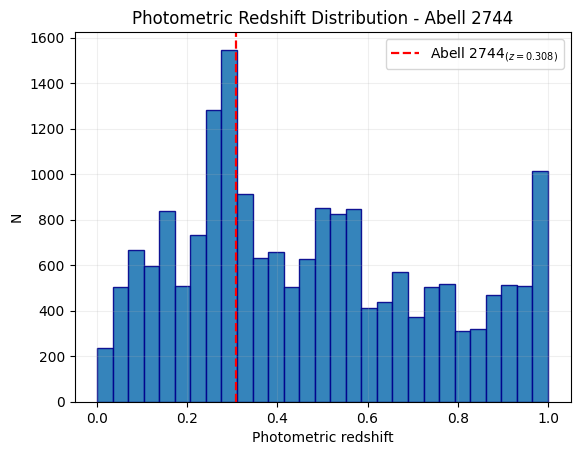

In [61]:
plt.hist(zout['z_phot'], bins=np.linspace(0, 1, 30), edgecolor='darkblue', alpha=0.9)
minl = 0.2
maxl = 0.4
#plt.axvline(minl, linestyle='--', color='red', label='z = ' + str(minl))
#plt.axvline(maxl, linestyle='--', color='red', label='z = ' + str(maxl))
plt.axvline(0.308, linestyle='--', color='red', linewidth=1.6, label='Abell $2744_{(z = 0.308)}$')
plt.grid(alpha=0.2)
plt.legend()
plt.xlabel('Photometric redshift'); plt.ylabel('N'); plt.title('Photometric Redshift Distribution - Abell 2744')
## Likelihood that a particular galaxy is a cluster member -> galaxies < 0 and > 7.5 are foreground/background objects?

(16.0, 25.0)

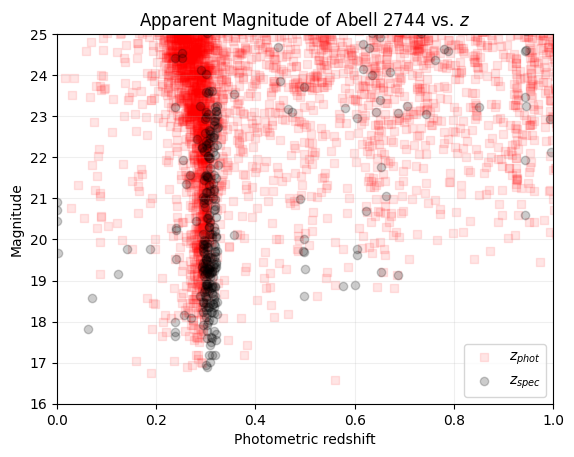

In [62]:
plt.scatter(zout['z_phot'], mag_f150, marker='s', alpha=0.1, label='$z_{phot}$', color='red')
plt.scatter(zout['z_spec'], mag_f150, marker='o', alpha=0.2, label='$z_{spec}$', color='black')
plt.legend(); plt.title(f'Apparent Magnitude of Abell 2744 vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')
plt.grid(alpha=0.2)
plt.xlim(0, 1); plt.ylim(16, 25)

### min/max range to help select cluster members

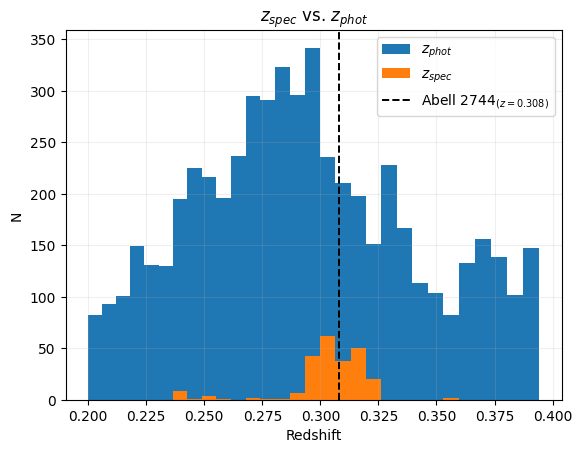

In [19]:
plt.hist(zout['z_phot'], bins=eazy.utils.log_zgrid([0.20,0.40], 0.005), label='$z_{phot}$')
plt.hist(zout['z_spec'], bins=eazy.utils.log_zgrid([0.20,0.40], 0.005), label='$z_{spec}$')
plt.axvline(0.308, linestyle='--', color='black', linewidth=1.4, label='Abell $2744_{(z = 0.308)}$')
plt.xlabel('Redshift'); plt.ylabel('N')
plt.grid(alpha=0.2)
plt.title('$z_{spec}$ vs. $z_{phot}$')
plt.legend()

## Colour-colour diagrams

### Using EAZY rest_frame_fluxes()

In [20]:
"""
_ubvj = (,,) ->
ubvj_tempfilt = rf integrated template fluxes (total through a filter)
ubvj_lc = rf pivot wavelengths (effective wavelength based on filter's transmission properties)
ubvj = rf fluxes
"""
_ubvj = self.rest_frame_fluxes(simple=True)
UBVJ = [153,154,155,161] # default UBVJ filters
self.ubvj_tempfilt, self.ubvj_lc, self.ubvj = _ubvj
self.ubvj_f_numbers = UBVJ
      
restU_eazy = self.ubvj[:,0,2] # flux density
restV_eazy = self.ubvj[:,2,2]
restJ_eazy = self.ubvj[:,3,2]

UV_eazy = -2.5*np.log10(restU_eazy/restV_eazy) # rest-frame with AB magnitude
VJ_eazy = -2.5*np.log10(restV_eazy/restJ_eazy)

Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 REST_FRAME/maiz-apellaniz_Johnson_U.res 2006AJ....131.1184M lambda_c= 3.5900e+03 AB-Vega= 0.769 w95=862.3
   1 REST_FRAME/maiz-apellaniz_Johnson_B.res 2006AJ....131.1184M lambda_c= 4.3722e+03 AB-Vega=-0.106 w95=1321.3
   2 REST_FRAME/maiz-apellaniz_Johnson_V.res 2006AJ....131.1184M lambda_c= 5.4794e+03 AB-Vega= 0.002 w95=1369.1
   3 2MASS/J.res lambda_c= 1.2358e+04 AB-Vega= 0.885 w95=2311.1
 ... (simple=True) no filter reweighting


### Using zout and sps_parameters()

In [21]:
restU = zout['restU'] # mJy
restV = zout['restV']
restJ = zout['restJ']

UV = -2.5*np.log10(restU/restV) 
VJ = -2.5*np.log10(restV/restJ) 

### Using filters

In [22]:
#for i in range(self.NFILT):
print(self.flux_columns[6], self.pivot[6]/(1+0.308)) # rest-frame wavelengths
print(self.flux_columns[14], self.pivot[14]/(1+0.308))
print(self.flux_columns[19], self.pivot[19]/(1+0.308))


f150w_tot_1 11473.589379340989
f435w_tot_1 3301.8563471780494
f814w_tot_1 6159.69381444031


In [23]:
# F435, F814, F150 (U, V, J)
filt_U = phot['f435w_tot_1'] * (1+0.308)
filt_V = phot['f814w_tot_1'] * (1+0.308)
filt_J = phot['f150w_tot_1'] * (1+0.308)

filt_UV = -2.5*np.log10(filt_U/filt_V)
filt_VJ = -2.5*np.log10(filt_V/filt_J) 

### Plotting UV-VJ

Text(0.5, 1.0, 'UVJ diagram - master')

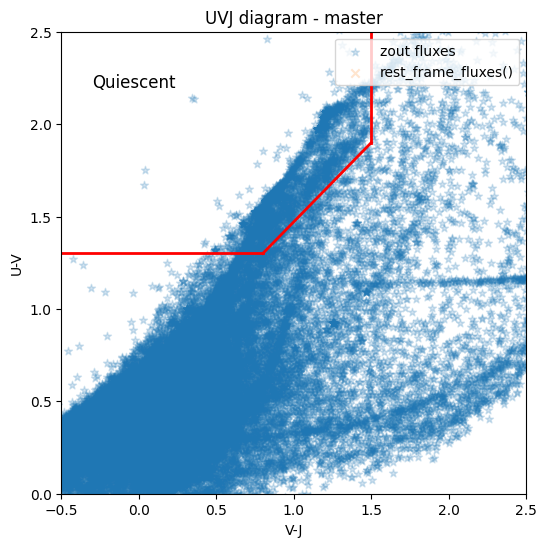

In [24]:
fig, ax = plt.subplots(figsize=(6, 6)) # top left part is quiescent

# lines based on Muzzin 2013
ax.plot([-0.5,0.8],[1.3,1.3],'r',lw=2) # left
ax.plot([0.8,1.5],[1.3,1.9],'r',lw=2) # diag
ax.plot([1.5,1.5],[1.9,2.5],'r',lw=2) # top

plt.scatter(VJ, UV, alpha=0.2, marker='*', label='zout fluxes')
plt.scatter(VJ_eazy, UV_eazy, alpha=0.2, marker='x', label='rest_frame_fluxes()')
#plt.scatter(filt_VJ, filt_UV, alpha=0.2, marker='o', label='filt')
plt.xlabel('V-J'); plt.ylabel('U-V')
plt.xlim(-0.5, 2.5); plt.ylim(0, 2.5)
plt.legend(loc='upper right')
ax.text(-0.3,2.2,'Quiescent',fontsize=12)
plt.title('UVJ diagram - master')

# dusty star-forming galaxies are red in V–J, quiescent galaxies are blue in V–J

### Creating a master dataframe of (z, U, V, J) to index by redshift


In [25]:
df = pd.DataFrame()

df['z_phot'] = list(zout['z_phot'])
df['U'] = list(restU)
df['V'] = list(restV)
df['J'] = list(restJ)
df['mag'] = mag_f150

df['mag'] = df['mag'].fillna(-1)
df = df[df['mag'] > -1] # only valid ones now

df

,z_phot,U,V,J,mag
11,3.273083,0.026003,0.032111,0.013620,27.631498
12,1.369503,0.053349,0.051153,0.066844,26.647478
13,0.592300,0.213709,0.401163,0.542543,24.559325
14,0.943194,0.007413,0.011538,0.017594,28.721071
15,7.010970,0.025280,0.027247,0.016078,27.291574
...,...,...,...,...,...
47883,3.093199,0.030869,0.045687,0.183679,30.672397
47884,0.732545,0.038687,0.068179,0.077431,27.014255
47885,0.672800,0.318292,1.059566,6.777478,22.412344
47886,0.340983,0.028254,0.042784,0.059217,26.690017


### UVJ diagram functions

In [26]:
def UVJ_diagram(df):
    """ For a given dataframe of shape (z, U, V, J, mag), 
        return the minimum and maximum z and UV and VJ bands
    """
    min_z = min(df['z_phot'])
    max_z = max(df['z_phot'])
    UV = -2.5*np.log10(df['U']/df['V'])
    VJ = -2.5*np.log10(df['V']/df['J'])
    
    return min_z, max_z, VJ, UV

def line(x):
    y = 0.857*x + 0.614
    return y

def plot_df_subsets(zs, cut='', alpha=0.1):
    """ Subplots for each range of z in zs (also cuts for magnitude if applicable)
    """
    props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

    if len(zs) == 1: # only one plot:
        a, b = list(UVJ_diagram(zs[0])[2]), list(UVJ_diagram(zs[0])[3])
        for q in range(len(a)):
            if (a[q] < 0.8 and b[q] > 1.3) or (0.8 < a[q] < 1.5 and b[q] > line(a[q])) or (a[q] < 1.5 and b[q] > 1.9):
                plt.scatter(a[q], b[q], color='red', alpha=alpha, marker='*') 
            else:
                plt.scatter(a[q], b[q], color='tab:blue', alpha=alpha, marker='*')

        plt.scatter(-1,2, color='red', alpha=0.5, marker='*', label='Quiescent') 
        plt.scatter(3,0.5, color='tab:blue', alpha=0.5, marker='*', label='Star-Forming') 
        plt.legend(loc='lower right', fontsize='small')

        plt.xlim(-0.5, 2.5); plt.ylim(0, 2.5) 
        plt.text(-0.2, 2.2, "{:.2f}".format(round(UVJ_diagram(zs[0])[0], 2))+' $\leq$ $z$ $\leq$ '+str(round(UVJ_diagram(zs[0])[1], 2)),fontsize=10)
        plt.xlabel('V-J'); plt.ylabel('U-V'); plt.grid(alpha=0.7); plt.title('UVJ Diagram - Abell 2744' + cut)

        # Plotting lines
        plt.plot([-0.5,0.8],[1.3,1.3],'k',lw=2); plt.plot([0.81,1.5],[1.3,1.9],'k',lw=2); plt.plot([1.5,1.5],[1.9,2.5],'k',lw=2) 

        return

    fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
    fig.suptitle('UVJ Diagram - Abell 2744' + ' (' + cut + ')')

    for i, variable in enumerate(zs):
        x = i//2; y = i%2 

        a, b = list(UVJ_diagram(zs[i])[2]), list(UVJ_diagram(zs[i])[3])

        for q in range(len(a)):
            if (a[q] < 0.8 and b[q] > 1.3) or (0.8 < a[q] < 1.5 and b[q] > line(a[q])) or (a[q] < 1.5 and b[q] > 1.9):
                axs[x,y].scatter(a[q], b[q], color='red', alpha=alpha, marker='*') 
            else:
                axs[x,y].scatter(a[q], b[q], color='tab:blue', alpha=alpha, marker='*') 

        axs[x,y].scatter(-1,2, color='red', alpha=0.5, marker='*', label='Quiescent') 
        axs[x,y].scatter(3,0.5, color='tab:blue', alpha=0.5, marker='*', label='Star-Forming') 
        axs[x,y].legend(loc='lower right', fontsize='x-small')

        axs[x,y].set_xlim(-0.5, 2.5); axs[x,y].set_ylim(0, 2.5)
        axs[x,y].text(-0.2, 2.2, "{:.2f}".format(round(UVJ_diagram(zs[i])[0], 2))+' $\leq$ $z$ $\leq$ '+str(round(UVJ_diagram(zs[i])[1], 2)),fontsize=10)
        axs[x,y].set_xlabel('V-J')
        axs[x,y].set_ylabel('U-V')  

        axs[x,y].grid(alpha=0.7)

        # Plotting lines
        axs[x,y].plot([-0.5,0.8],[1.3,1.3],'k',lw=2) # left
        axs[x,y].plot([0.81,1.5],[1.3,1.9],'k',lw=2) # diag
        axs[x,y].plot([1.5,1.5],[1.9,2.5],'k',lw=2) # top

    plt.tight_layout()
    plt.show()

    return # concentrated cluster galaxies & background galaxies deviating in colour?

### Creating dataframes for different ranges of redshift

In [27]:
z1 = df[(df['z_phot'] >= 0.12) & (df['z_phot'] <= 0.25)]
z2 = df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.32)] 
z3 = df[(df['z_phot'] > 0.32) & (df['z_phot'] <= 0.50)]
z4 = df[(df['z_phot'] > 0.50) & (df['z_phot'] <= 0.65)]
z5 = df[(df['z_phot'] > 0.65) & (df['z_phot'] <= 0.85)]
z6 = df[(df['z_phot'] > 0.85) & (df['z_phot'] <= 1.0)]

zs_full=[z1,z2,z3,z4 ,z5, z6]

c = 0
for z in zs_full:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

2481
2714
2524
2416
2058
2057
37.074617546050575 %


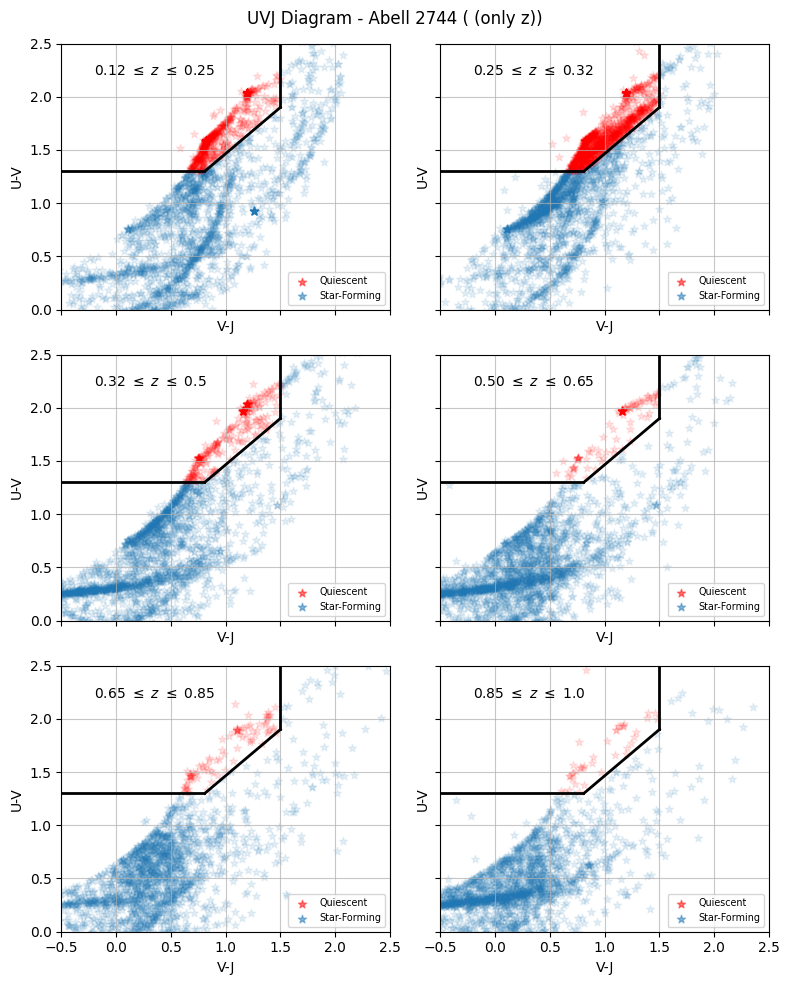

In [28]:
plot_df_subsets(zs_full, cut=' (only z)')

## Zooming into cluster!

4362
11.348735560412115 %


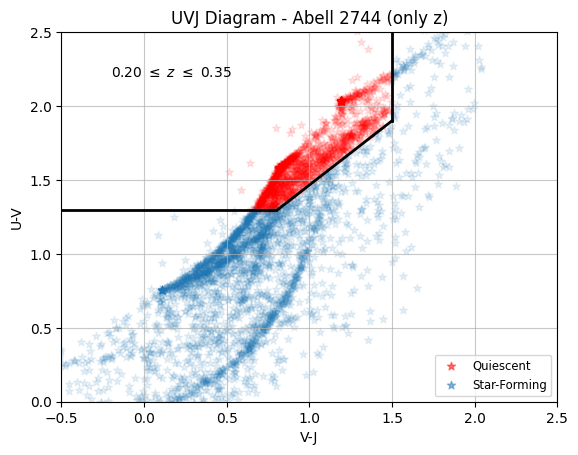

In [29]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] > 0.20) & (df['z_phot'] <= 0.35)]

zs_zoom=[z1]

c = 0
for z in zs_zoom:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

plot_df_subsets(zs_zoom, cut=' (only z)')

## Magnitude

In [30]:
#plt.hist(mag_f150, bins=np.linspace(18, 35, 100), label='F150')
#plt.hist(np.unique(mag_f814), bins=np.linspace(18, 35, 100), label='F814 (unique)')
#plt.hist(mag_f160, bins=np.linspace(18, 35, 100), label='F160')
#plt.xlabel('Magnitude')
#plt.title('Magnitudes of different filters')
#plt.legend()


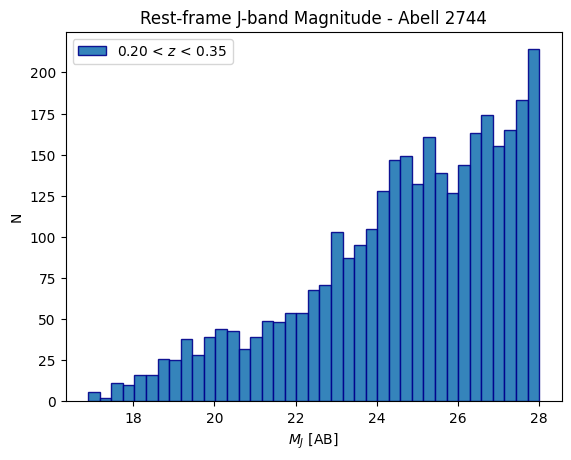

In [69]:
# NO MAGNITUDE BINS:
df_cut =  df[(df['z_phot'] > 0) & (df['z_phot'] <= 18)]
df_cut1 =  df[(df['z_phot'] > 0.20) & (df['z_phot'] <= 0.35)]
              
plt.hist(df_cut1['mag'], bins=np.linspace(min(df_cut1['mag']), 28, 40), label='0.20 < $z$ < 0.35', edgecolor='darkblue', alpha=0.9) # changed bins here from 100

plt.ylabel('N')
plt.xlabel('$M_J$ [AB]')
plt.title('Rest-frame J-band Magnitude - Abell 2744')
plt.legend(fontsize='small', loc='upper left')

plt.legend()

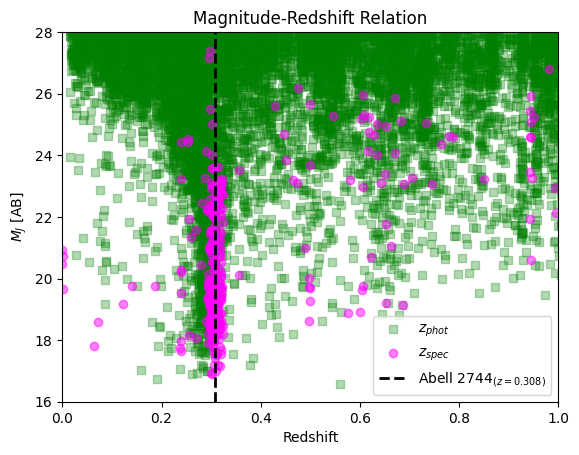

In [76]:
plt.scatter(zout['z_phot'], mag_f150, marker='s', alpha=0.3, label='$z_{phot}$', color='green')
plt.scatter(zout['z_spec'], mag_f150, marker='o', alpha=0.5, label='$z_{spec}$', color='magenta')
plt.title('Magnitude-Redshift Relation')
plt.ylabel('$M_J$ [AB]'); plt.xlabel('Redshift')

plt.xlim(0, 1); plt.ylim(16, 28)
plt.axvline(0.308, color='black', linestyle='--', linewidth=2, label='Abell $2744_{(z = 0.308)}$')
plt.legend()

### Binning for magnitude - UVJ Diagrams

In [33]:
# Creating dataframes for different ranges of magnitude (on top of redshift)
## ZOOMED
ms_zoom = []
for z in zs_zoom:
    m_cut = z[(z['mag'] >= 18) & (z['mag'] <= 25)]
    ms_zoom.append(m_cut)
print('zoomed:')
for m in ms_zoom:
    print(len(m))

print()

## FULL
ms_full = []
for z in zs_full:
    m_cut = z[(z['mag'] >= 18) & (z['mag'] <= 25)]
    ms_full.append(m_cut)
print('full:')
for m in ms_full:
    print(len(m))

zoomed:
1575

full:
259
1268
340
252
308
210


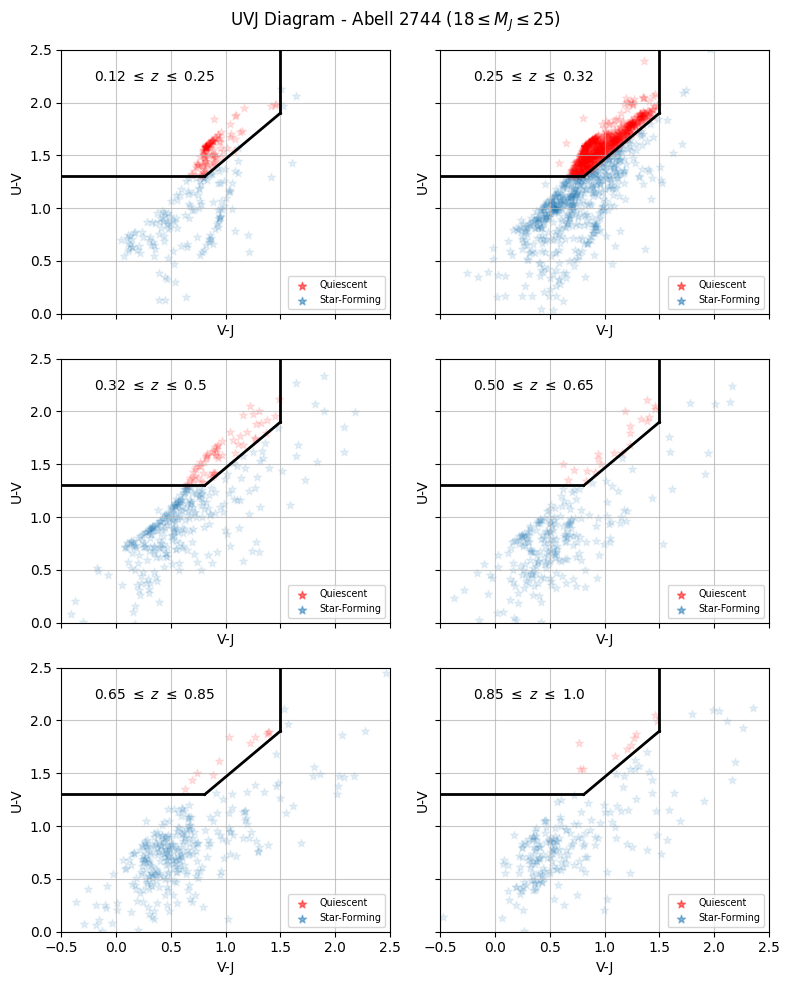

In [34]:
plot_df_subsets(ms_full, cut='$18 \leq M_J \leq 25$', alpha=0.1)

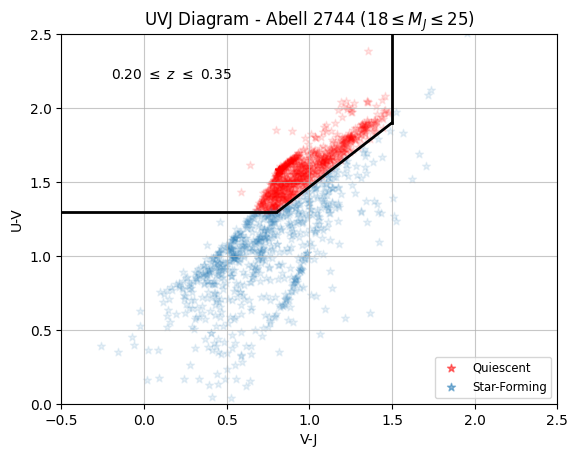

In [35]:
plot_df_subsets(ms_zoom, cut=' ($18 \leq M_J \leq 25$)', alpha=0.1)

## Luminosity Function

0 3
1 4
2 18
3 26
4 32
5 43
6 66
7 76
8 83
9 87
10 94
11 99
12 100
13 129
14 133
15 168
16 178
17 185
18 214
19 223
20 225
21 228
22 229
23 242
24 247
25 249
26 254
27 263
28 264
29 284
30 297
31 299
32 315
33 349
34 368
35 374
36 378
37 391
38 392
39 393
40 434
41 443
42 445
43 467
44 482
45 488
46 507
47 516
48 543
49 544
50 547
51 561
52 566
53 576
54 583
55 585
56 634
57 638
58 647
59 654
60 656
61 657
62 658
63 660
64 663
65 676
66 682
67 684
68 687
69 702
70 717
71 729
72 735
73 736
74 747
75 751
76 752
77 754
78 778
79 781
80 782
81 787
82 808
83 809
84 816
85 817
86 828
87 831
88 850
89 867
90 870
91 887
92 900
93 905
94 910
95 916
96 919
97 921
98 932
99 939
100 943
101 963
102 968
103 981
104 989
105 993
106 1003
107 1019
108 1023
109 1054
110 1102
111 1108
112 1113
113 1135
114 1144
115 1162
116 1164
117 1174
118 1176
119 1177
120 1179
121 1182
122 1186
123 1195
124 1202
125 1206
126 1207
127 1208
128 1229
129 1231
130 1233
131 1260
132 1264
133 1293
134 1302
135 1322
136 13

993 9807
994 9811
995 9813
996 9883
997 9887
998 9922
999 9935
1000 9937
1001 9971
1002 9973
1003 9976
1004 9981
1005 10000
1006 10003
1007 10019
1008 10037
1009 10042
1010 10045
1011 10049
1012 10050
1013 10053
1014 10075
1015 10091
1016 10116
1017 10126
1018 10132
1019 10173
1020 10185
1021 10208
1022 10214
1023 10215
1024 10218
1025 10234
1026 10237
1027 10240
1028 10265
1029 10272
1030 10305
1031 10315
1032 10320
1033 10328
1034 10331
1035 10335
1036 10350
1037 10362
1038 10366
1039 10385
1040 10387
1041 10405
1042 10418
1043 10423
1044 10426
1045 10438
1046 10447
1047 10501
1048 10518
1049 10526
1050 10529
1051 10540
1052 10554
1053 10557
1054 10560
1055 10583
1056 10591
1057 10594
1058 10602
1059 10606
1060 10607
1061 10623
1062 10636
1063 10638
1064 10649
1065 10673
1066 10674
1067 10683
1068 10723
1069 10742
1070 10747
1071 10762
1072 10764
1073 10775
1074 10795
1075 10807
1076 10820
1077 10827
1078 10832
1079 10846
1080 10849
1081 10871
1082 10877
1083 10888
1084 10890
1085 10

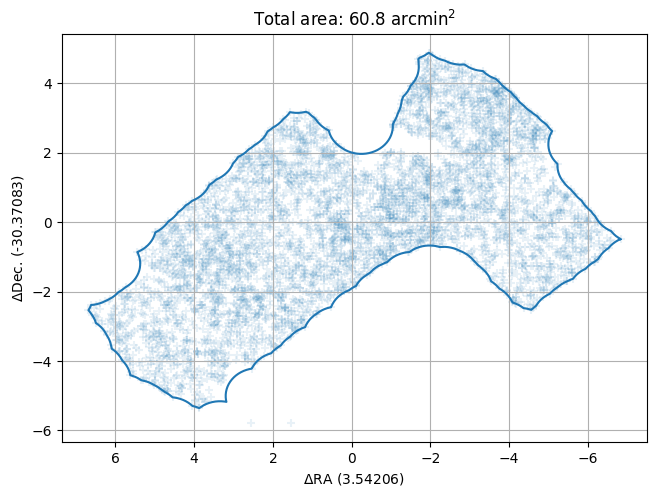

In [36]:
area, area_fig = grizli.utils.catalog_area(phot['ra'], phot['dec']) # square arcminutes

In [37]:
# Calculate phi_star
def normalization_param(z1, z2, area):
    """ Calculates the normalization parameter, phi_star, of the Schechter luminosity function
        z1, z2: differential redshift (should correspond to redshift of magnitudes inputted)
        area: catalog area (unitless)
        N: number of galaxies total
        mag: list of magnitudes
    """
    area *=  u.arcmin**2
    area_ster = area.to(u.steradian, equivalencies=u.dimensionless_angles())
    vol_in = WMAP9.comoving_volume(z1)
    vol_out = WMAP9.comoving_volume(z2)
    vol_area = (area_ster / ((2 * np.pi)*u.steradian)) * abs(vol_out-vol_in) # vol * area
    return vol_area # Mpc^3

# Schechter function:
def schechter(mag, phi_star=11, M_star=-21.9,a=-1.21):
    func = (phi_star) * 0.4*np.log(10) * (10**(0.4*(M_star-mag)))**(a+1) / np.exp(10**(0.4*(M_star-mag)))   
    return func

# Double Schechter function:
def double_schechter(mag1,phi_star1,M_star1,a1,mag2,phi_star2,M_star2,a2): 
    func1 = (phi_star1) * 0.4*np.log(10) * (10**(0.4*(M_star1-mag1)))**(a1+1) / np.exp(10**(0.4*(M_star1-mag1)))   
    func2 = (phi_star2) * 0.4*np.log(10) * (10**(0.4*(M_star2-mag2)))**(a2+1) / np.exp(10**(0.4*(M_star2-mag2)))   
    return func1 + func2

(0.0001, 1.0)

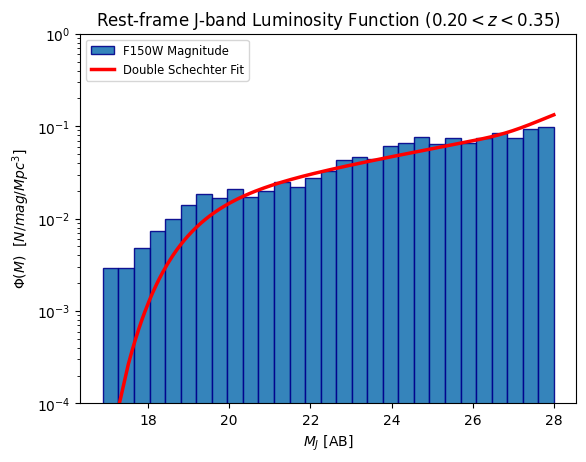

In [128]:
## Histogram
df_cut_z =  df[(df['z_phot'] > 0.20) & (df['z_phot'] <= 0.35)]
data = df_cut_z['mag'][(df_cut_z['mag'] >= 16.8) & (df_cut_z['mag'] <= 28)]
norm = normalization_param(0.20, 0.35, area)

## Schechter (single and double)
sch = schechter(data, phi_star=0.0045, M_star=16.8,a=-1.21)
double_sch = double_schechter(mag1=data, phi_star1=0.0195, M_star1=19, a1=-1.21, mag2=data, phi_star2=0.09, M_star2=28, a2=-1.21)

mag_sort, sch_sort = zip(*sorted(zip(data, sch)))
mag_sort, doub_sch_sort = zip(*sorted(zip(data, double_sch)))

## Plotting
plt.hist(data, bins=np.linspace(min(data), 28, 30), weights=np.ones_like(data)/((28-min(data))/30)/norm, edgecolor='darkblue', alpha=0.9, label='F150W Magnitude')
plt.plot(mag_sort, doub_sch_sort, color='red', linewidth=2.5, label='Double Schechter Fit')

plt.xlabel('$M_J$ [AB]')
plt.ylabel('$\Phi(M)$  $[N/mag/Mpc^3]$')
plt.title('Rest-frame J-band Luminosity Function $(0.20 < z < 0.35)$')
plt.legend(fontsize='small', loc='upper left')
plt.yscale('log'); plt.ylim(1e-4, 1e0)

### Curve-fitting LF

Text(0, 0.5, '$\\Phi(M)$  $[N/mag/Mpc^3]$')

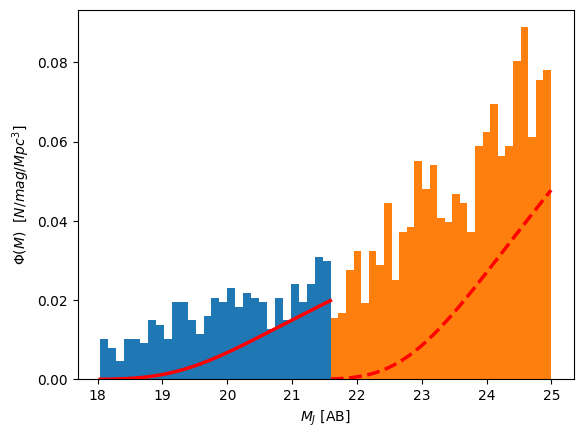

In [83]:
### SPLITTING
x1 = np.array(mag_sort[0:430])
y1 = schechter(x1, phi_star=0.02, M_star=20,a=-1.21)
x2 = np.array(mag_sort[430:])
y2 = schechter(x2, phi_star=0.05, M_star=23.5,a=-1.21)

bin1, bin2 = mag_sort[0], mag_sort[430]
bin3, bin4 = mag_sort[430], mag_sort[1574]

plt.hist(x1, bins=np.linspace(bin1, bin2, 30), weights=np.ones_like(x1)/((bin2-bin1)/30)/norm)
plt.plot(x1, y1, color='red', linewidth=2.5)

plt.hist(x2, bins=np.linspace(bin3, bin4, 30), weights=np.ones_like(x2)/((bin4-bin3)/30)/norm)
plt.plot(x2, y2, color='red', linestyle='--', linewidth=2.5)

#plt.yscale('log')

plt.xlabel('$M_J$ [AB]')
plt.ylabel('$\Phi(M)$  $[N/mag/Mpc^3]$')

In [40]:
popt1, pcov1 = curve_fit(schechter, x1, y1, p0=[0.01, 19, -1.3], sigma=np.sqrt(y1), absolute_sigma=True, bounds=([0, 15, -2], [0.10, 25, 0])) 
popt2, pcov2 = curve_fit(schechter, x2, y2, p0=[0.060, 25, -1.1], sigma=np.sqrt(y2), absolute_sigma=True, bounds=([0, 15, -2], [0.10, 25, 0])) 

print(popt1)
print(popt2)


[ 2.00e-02  2.00e+01 -1.21e+00]
[ 0.05 23.5  -1.21]


(0.0001, 1.0)

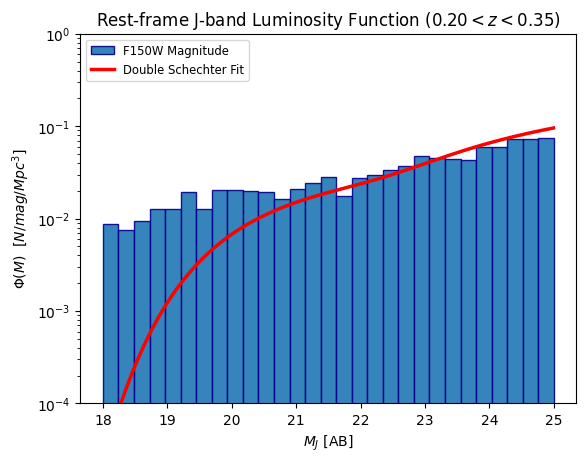

In [41]:
## Plotting
plt.hist(df_cut1['mag'], bins=np.linspace(18, 25, 30), weights=np.ones_like(data)/((25-18)/30)/norm, edgecolor='darkblue', alpha=0.9, label='F150W Magnitude')

double_sch_fit = double_schechter(mag1=ms_zoom[0]['mag'], phi_star1=popt1[0], M_star1=popt1[1], a1=popt1[2], mag2=ms_zoom[0]['mag'], phi_star2=popt2[0], M_star2=popt2[1], a2=popt2[2])
mag_sort_fit, sch_sort_fit = zip(*sorted(zip(ms_zoom[0]['mag'], double_sch_fit)))

plt.plot(mag_sort_fit, sch_sort_fit, color='red', linewidth=2.5, label='Double Schechter Fit')
#plt.errorbar(mag_sort_fit, sch_sort_fit, yerr=np.concatenate((np.sqrt(y1), np.sqrt)), fmt='o', color='purple', alpha=0.2, label='Data with Error Bars')

plt.xlabel('$M_J$ [AB]')
plt.ylabel('$\Phi(M)$  $[N/mag/Mpc^3]$')
plt.title('Rest-frame J-band Luminosity Function $(0.20 < z < 0.35)$')
plt.legend(fontsize='small', loc='upper left')
plt.yscale('log')
plt.ylim(1e-4, 1e0)

## Star formation rate!

In [132]:
# Creating a master dataframe of stellar masses etc
stellar_df = pd.DataFrame()

stellar_df['stellar_mass'] = list(zout['mass'])
stellar_df['sfr'] = list(zout['sfr'])
stellar_df['z'] = list(zout['z_phot'])
stellar_df['dL'] = list(zout['dL']) # Mpc
stellar_df['mag'] = list(23.9 - 2.5*np.log10(phot['f150w_tot_1']))

stellar_df = stellar_df[stellar_df['stellar_mass'] > 0] # only valid ones now

stellar_df_only_mag = stellar_df[(stellar_df['mag'] >= 18) & (stellar_df['mag'] <= 23)]

stellar_df = stellar_df[(stellar_df['mag'] >= 18) & (stellar_df['mag'] <= 23)]
stellar_df = stellar_df[(stellar_df['z'] >= 0.20) & (stellar_df['z'] <= 0.35)]
stellar_df.sort_values(by=['stellar_mass'])

,stellar_mass,sfr,z,dL,mag
1886,9.953114e+07,0.082002,0.213542,1054.650385,22.858042
7352,1.038811e+08,1.405877,0.271236,1382.924788,22.089619
30746,1.578369e+08,0.038028,0.204362,1003.981726,22.959653
18559,1.843253e+08,0.085687,0.228996,1140.937012,22.964982
11130,2.264551e+08,0.177044,0.239164,1198.374050,22.246720
...,...,...,...,...,...
40292,5.464031e+10,1.649718,0.291175,1500.185097,18.180371
39858,5.835667e+10,2.991767,0.335755,1769.086012,18.667170
19449,6.307416e+10,2.034158,0.296464,1531.607487,18.112108
19448,6.434134e+10,2.021522,0.295694,1527.026941,18.073416


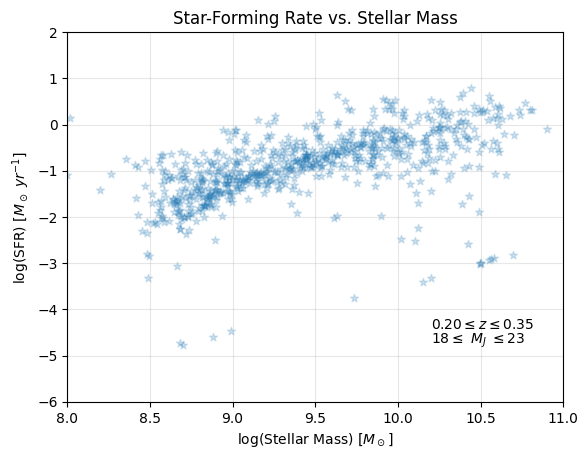

In [165]:
x_sfr = np.log10(stellar_df['stellar_mass'])
y_sfr = np.log10(stellar_df['sfr'])

plt.scatter(x_sfr, y_sfr, alpha=0.2, marker='*')
plt.xlabel('log(Stellar Mass) [$M_\odot$]'); plt.ylabel('log(SFR) [$M_\odot \ yr^{-1}$]')
plt.title('Star-Forming Rate vs. Stellar Mass')
plt.text(10.2, -4.43, '$0.20 \leq z \leq 0.35$',fontsize=10)
plt.text(10.199, -4.73, '$18 \leq$ $M_J$ $\leq 23$',fontsize=10)
plt.ylim(-6, 2); plt.xlim(8, 11)
plt.grid(alpha=0.3)

In [228]:
min(np.log10(stellar_df['stellar_mass'])), max(np.log10(stellar_df['stellar_mass']))

(7.997958966021128, 10.901655855421522)

0.6582403382986091 -7.1077996830111


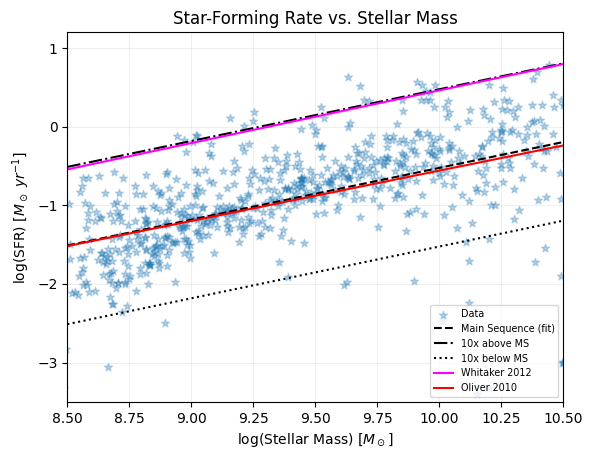

In [231]:
x_sfr = np.log10(stellar_df['stellar_mass'])
x_sfr_data = np.linspace(8.5, 10.5, 40)
y_sfr = np.log10(stellar_df['sfr'])

def linear(x, m, b):
    return m*x + b

popt, pcov = curve_fit(linear, x_sfr, y_sfr)

m, b = popt
print(*popt)

y_fit = linear(x_sfr_data, m, b)
y_above = linear(x_sfr_data, m, np.log10(10**b*10))
y_below = linear(x_sfr_data, m, np.log10(10**b/10))
whitaker = linear(x_sfr_data, 0.67, -6.24)
oliver = linear(x_sfr_data, 0.64, -6.96)

# Plot
plt.scatter(x_sfr, y_sfr, alpha=0.3, marker='*', label='Data')
plt.plot(x_sfr_data, y_fit, color='k', linestyle='dashed', label='Main Sequence (fit)')
plt.plot(x_sfr_data, y_above, color='k', linestyle='dashdot', label='10x above MS')
plt.plot(x_sfr_data, y_below, color='k', linestyle='dotted', label='10x below MS')
plt.plot(x_sfr_data, whitaker, color='magenta', linestyle='solid', label='Whitaker 2012')
plt.plot(x_sfr_data, oliver, color='red', linestyle='solid', label='Oliver 2010')

#plt.text(8.75, 0.35, 'Starbursts')
#plt.text(9, -3, 'Quiescent')
#plt.text(8.61, -1.35, 'MS')

plt.legend(loc='lower right', fontsize='x-small')
plt.xlim(8.5, 10.5); plt.ylim(-3.5, 1.2)
plt.xlabel('log(Stellar Mass) [$M_\odot$]')
plt.ylabel('log(SFR) [$M_\odot \ yr^{-1}$]')
plt.title('Star-Forming Rate vs. Stellar Mass')
plt.grid(alpha=0.2)

In [45]:
def smf(phi_star, mag, M_star, a):
    phi = np.log(10) * phi_star * np.exp(-10**(np.log10(mag) - np.log10(M_star))) * (10**(np.log10(mag)-np.log10(M_star)))**(a+1)
    return phi

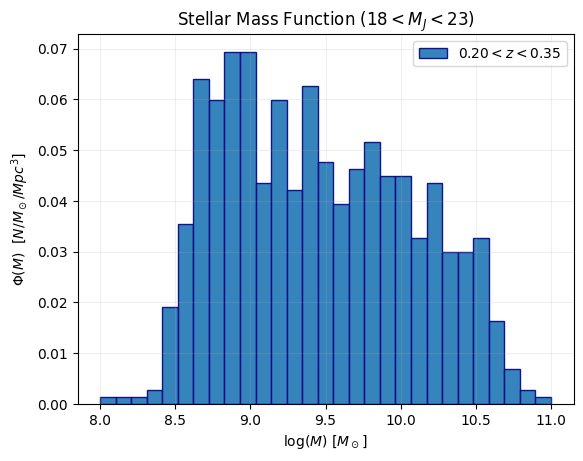

In [220]:
norm = normalization_param(0.20, 0.35, area)

mass_data = np.log10(stellar_df['stellar_mass'])
plt.hist(mass_data, bins=np.linspace(8, 11, 30), weights=np.ones_like(mass_data)/((11-8)/30)/norm, edgecolor='darkblue', alpha=0.9, label='$0.20 < z < 0.35$')

plt.xlabel('log($M$) [$M_\odot]$')
plt.ylabel('$\Phi(M)$  $[N/M_\odot/Mpc^3]$')
plt.title('Stellar Mass Function ($18 < M_J < 23$)')
plt.grid(alpha=0.2)
plt.legend()

In [ ]:
#plt.scatter(np.log10(stellar_df['stellar_mass']), np.log10(smf(phi_star=norm, M_star=stellar_df['stellar_mass'], M_char=10**10, a=-1.21)), linestyle='--')


Text(0.5, 0, 'z')

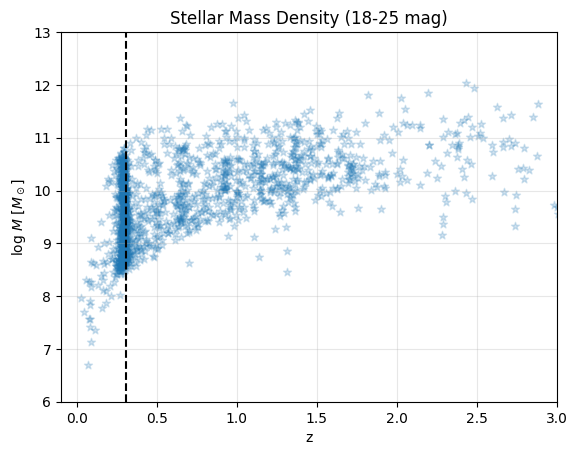

In [47]:
# 2d hist

plt.title('Stellar Mass Density (18-25 mag)')
plt.grid(alpha=0.3)
plt.scatter(stellar_df_only_mag['z'], np.log10(stellar_df_only_mag['stellar_mass']), alpha=0.2, marker='*')
plt.ylim(6, 13)
plt.xlim(-0.1, 3)
plt.axvline(0.308, color='k', linestyle='--')
plt.ylabel('log $M$ [$M_\odot$]'); plt.xlabel('z') 